# Import

In [1]:
import numpy as np
from obspy.clients.fdsn import Client
from obspy import read, read_inventory, UTCDateTime
from obspy.signal import PPSD
from obspy.imaging.cm import pqlx
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import os

plt.style.use('ggplot')
client = Client('IRIS')

---
# PSD with Mars raw data (BHU, BHV, BHW)

In [2]:
# Merge daily Mars continuous waveform

def waveform_merge():
    startdate = input("Enter startdate (YYYYMMDD) : ")
    enddate = str(int(input("Enter enddate (YYYYMMDD) : ")) + 1)
    
    mseed_dir = "화성 연속파형_" + startdate[:4] + "/"
    mseed_list = os.listdir(mseed_dir)
    mseed_startformat = "XB.ELYSE.02.BH1." + startdate + "0000.mseed"
    mseed_endformat = "XB.ELYSE.02.BH1." + enddate + "0000.mseed"

    st = read(mseed_dir + mseed_startformat)

    for mseed in mseed_list:
        if int(mseed.split('.')[4][:8]) >= int(startdate) and int(mseed.split('.')[4][:8]) <= int(enddate) - 1:
            merge = read(mseed_dir + mseed)
            st = st + merge
            st.merge(fill_value= 'interpolate')     
        else:
            continue
       
    print(st)

    return st


In [3]:
st = waveform_merge()

3 Trace(s) in Stream:
XB.ELYSE.02.BHU | 2021-01-03T00:00:00.041000Z - 2021-01-06T23:59:59.991000Z | 20.0 Hz, 6912000 samples
XB.ELYSE.02.BHV | 2021-01-03T00:00:00.041000Z - 2021-01-06T23:59:59.991000Z | 20.0 Hz, 6912000 samples
XB.ELYSE.02.BHW | 2021-01-03T00:00:00.041000Z - 2021-01-06T23:59:59.991000Z | 20.0 Hz, 6912000 samples


In [111]:
# Save merged waveform as mseed format

#st.write('XB.ELYSE.02.BH.20210101_20210228.mseed')

In [113]:
# run PPSD to get Power spectral density from continuous waveform and save as npz format
# first ppsd contains whole frequencies and second one contains specific frequency (0.3Hz ~ 10Hz)

tr = st[0]

inv = client.get_stations(starttime = UTCDateTime('2021-01-01T00:00:00.000'), endtime = UTCDateTime('2021-03-01T00:00:00.000'), 
                          network='XB', station='ELYSE', location='02', channel='BH*', level='response')

ppsd = PPSD(tr.stats, metadata= inv)
ppsd.add(tr)

ppsd2 = PPSD(tr.stats, metadata= inv, period_limits= (1/10, 1/0.3))
ppsd2.add(tr)

ppsd.save_npz('mars_20210101_20210228_raw.npz')
ppsd2.save_npz('mars_20210101_20210228.npz')

c:\Users\neimb\anaconda3\Lib\site-packages\obspy\signal\spectral_estimation.py:979: UserWarning: Error getting response from provided metadata:
Exception: No matching response information found.
Skipping time segment(s).
  warnings.warn(msg)


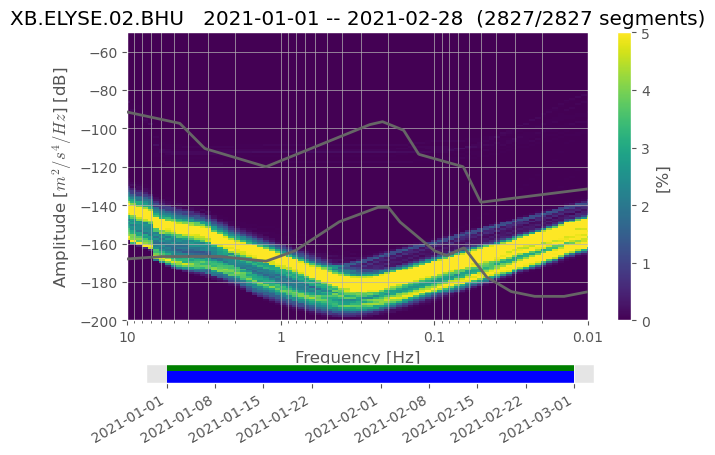

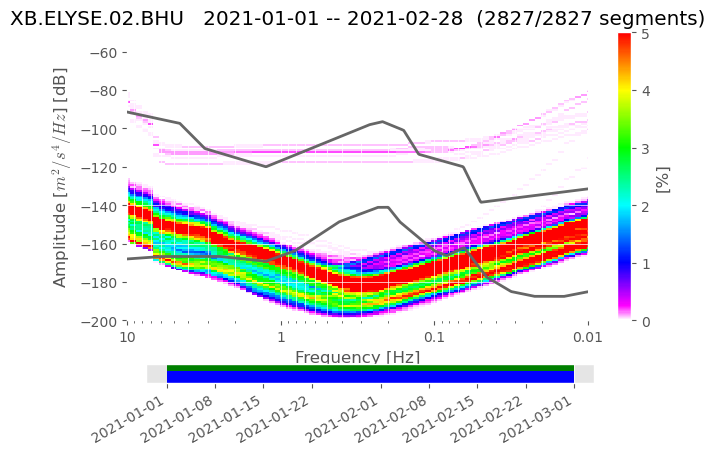

In [43]:
# plotting raw PPSD

example = PPSD.load_npz('mars_20210101_20210228_raw.npz')
example.plot(xaxis_frequency=True, period_lim= (10, 0.01), max_percentage=5);
example.plot(cmap = pqlx, xaxis_frequency=True, period_lim= (10, 0.01), max_percentage=5);

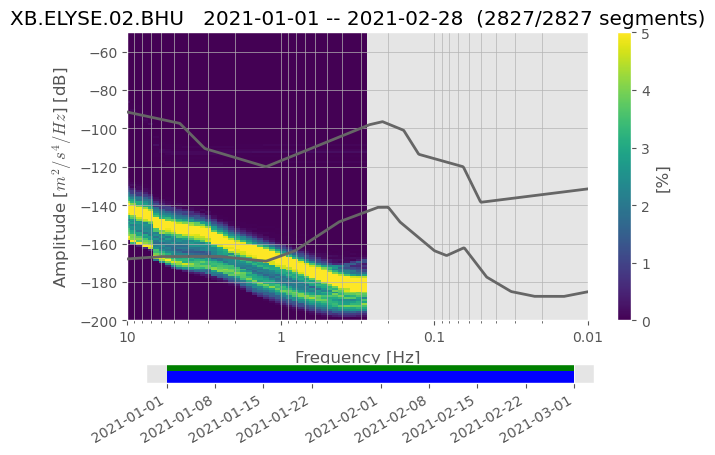

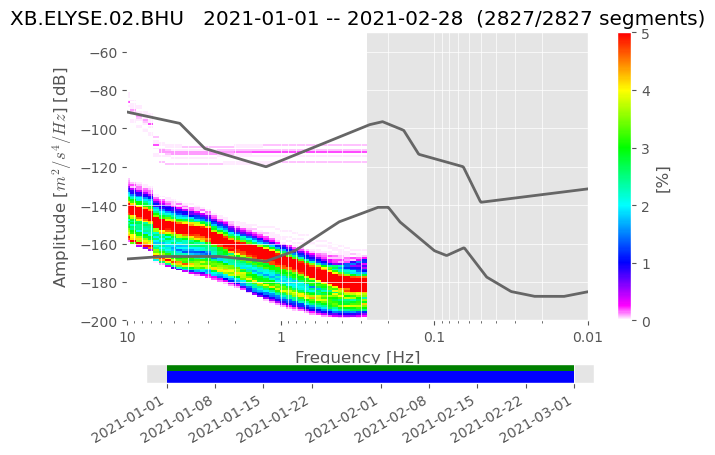

In [44]:
# plotting preprocessed PPSD

example = PPSD.load_npz('mars_20210101_20210228.npz')
example.plot(xaxis_frequency=True, period_lim= (10, 0.01), max_percentage=5);
example.plot(cmap = pqlx, xaxis_frequency=True, period_lim= (10, 0.01), max_percentage=5);

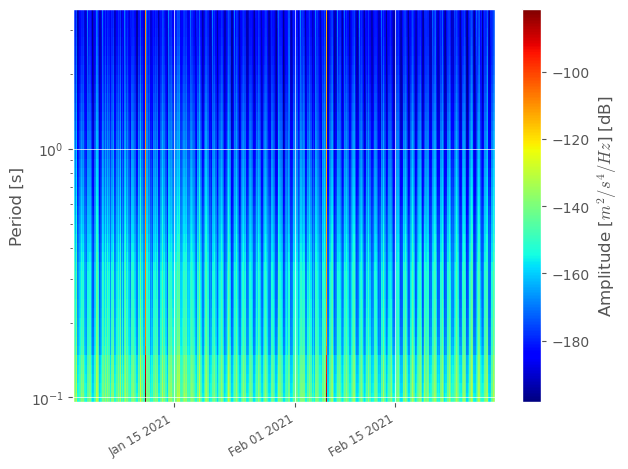

In [45]:
# plotting spectrogram with preprocessed PSD

example.plot_spectrogram(grid=False, cmap='jet');

(array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38, 39, 40], dtype=int64),)


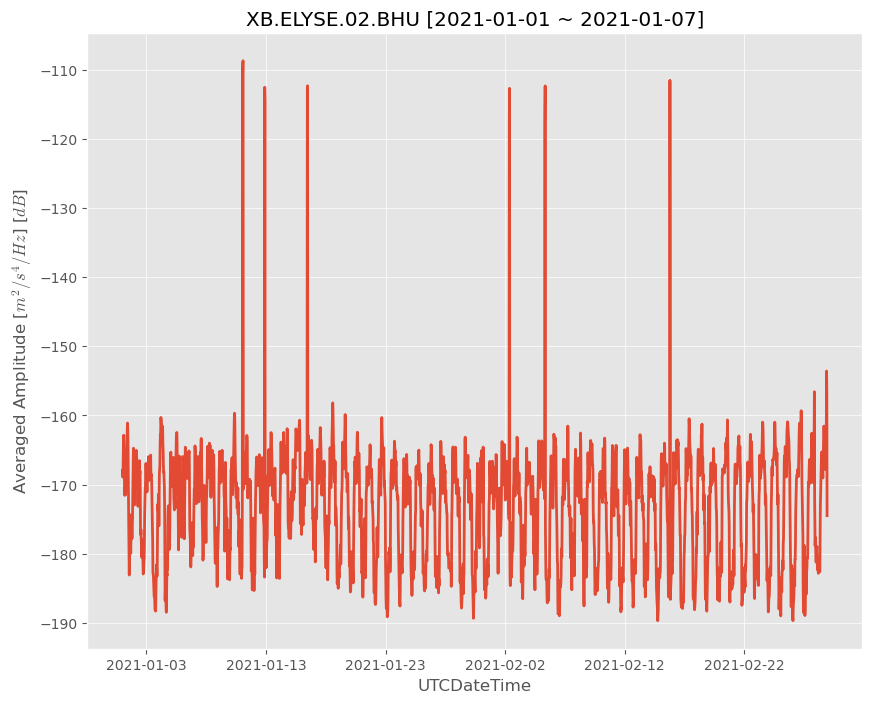

In [46]:
# Diurnal variation of averaged amplitude with each 1-hour windows 

import seaborn as sns
import matplotlib.dates as mdates

fre = example.get_percentile()[0]

freq = np.where((fre < 1 / 0.3) & (fre > 1 / 3.0))
print(freq)

avg_amplitude = []
time = []

for i in range(len(example.psd_values)):
    time.append(UTCDateTime(int(str(example._times_processed[i])[:10])).matplotlib_date)
    avg_amplitude.append(example.psd_values[i][14:40].mean())

fig, ax = plt.subplots(figsize = (10, 8))
plt.style.use(['bmh'])
ax.plot(time, avg_amplitude)
ax.set_xlabel('UTCDateTime')
ax.set_ylabel('Averaged Amplitude [$m^2 / s^4 / Hz$] [$dB$]')
ax.set_title('XB.ELYSE.02.BHU [2021-01-01 ~ 2021-01-07]')

xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)

C:\Users\neimb\AppData\Local\Temp\ipykernel_12984\2391475928.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / freqs, np.abs(dft))


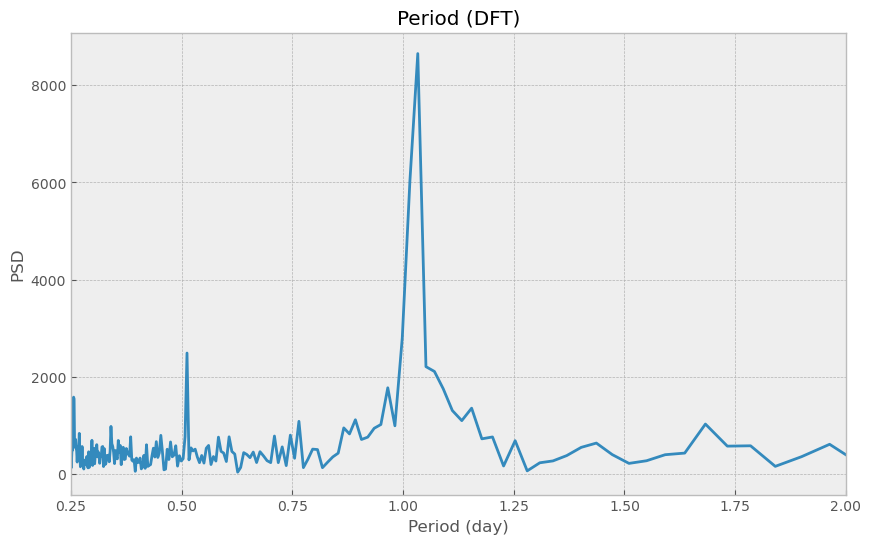

In [47]:
# Compute the Discrete Fourier Transform
dft = np.fft.rfft(avg_amplitude)
freqs = np.fft.rfftfreq(len(avg_amplitude), d=time[1]-time[0])  # Compute frequencies

# Plot the frequency spectrum
plt.figure(figsize=(10, 6))
plt.plot(1 / freqs, np.abs(dft))
plt.title('Period (DFT)')
plt.xlabel('Period (day)')
plt.ylabel('PSD')
plt.xticks([0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00])
plt.xlim(0.25, 2.0)
plt.grid(True)
plt.show()

---